In [1]:
# IMPORT VARIABLES, LIBRARIES AND FUNCTIONS
%matplotlib inline
import timeit

from analysis_funk import * # Stored functions and variables to plot the map of Paris
from mvp_funk import * 

print(data.shape, paris_attractions.shape)

(36858, 29) (449, 3)


---
# LOCATION: 
## What is the best district in terms of location? 
- What is the proportion of listings per district?

In [15]:
mys = data.loc[:,['zipcode','latitude','longitude','price','review_scores_location']].sample(frac=1)
mys.shape

(36858, 5)

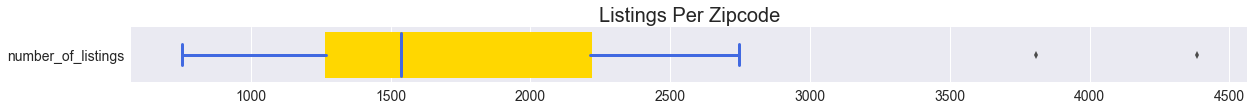

In [16]:
listings_per_zip = mys[['latitude','zipcode']].groupby('zipcode').count().rename(columns={'latitude':'number_of_listings'})
fig = plt.figure(figsize = (20,1))
sns.boxplot(data=listings_per_zip,
            orient="h", boxprops=dict(color='gold'), 
            capprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'),
            flierprops=dict(color='firebrick', markeredgecolor='firebrick'), 
            medianprops=dict(color='royalblue'))

plt.title('Listings Per Zipcode')
plt.show()

*We'll keep in mind that there are 2 districts that are overpopulated with listings: the 11th and 18th district. Whereas the 1st and the 8 have less than a thousand listings. This measure doesnt consider the density though, just the total number of listings.*

- What is the average PRICE of listings per district? Are there districts that can be considerably high or low? Consider the space
- can we see which arrondissement is most expensive in function of the musings price? Which arrondissement has the most pricey listings? Does it correlate with the number of amenities? Or space? 

In [17]:
data.price.describe()

count    36858.000
mean        98.628
std        120.335
min          8.000
25%         55.000
50%         75.000
75%        110.000
max       9379.000
Name: price, dtype: float64

When it comes to price, the listings can be divided in 2 ranges: 
    - 0 to 110$
    - 110$ to end

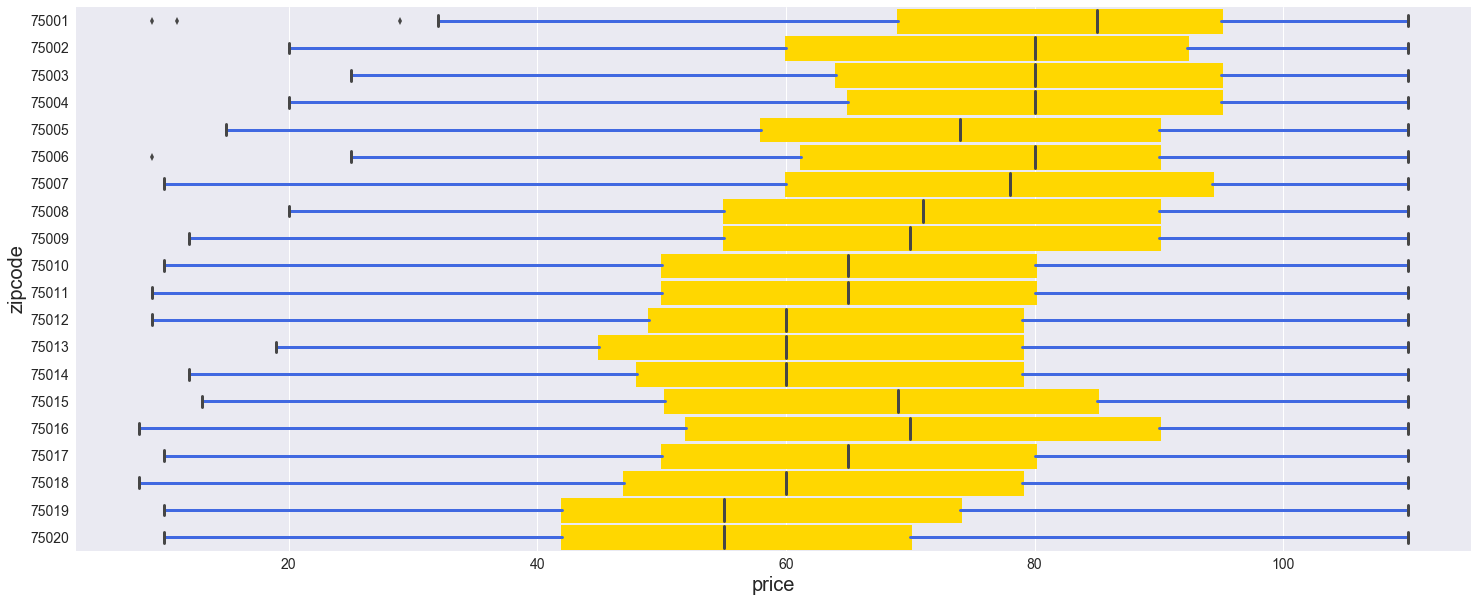

In [18]:
price_per_zip = data.loc[data.price<=110, ['zipcode','price']]
fig = plt.figure(figsize = (25,10))
sns.boxplot(x='price',y='zipcode' ,data=price_per_zip, orient='h',
            boxprops=dict(color='gold'),
            whiskerprops=dict(color='royalblue'))
plt.show()

For 75% of the listings, the median ranges from 50 to 90 dls and according to the plot above, the median is higher for districts closer to the center of the city (75001-75008) and slowly decreases for districts farther away from the center with the exception of the 16th district which is well-known to be one of the most expensive for . 

For the more expensive listings: 

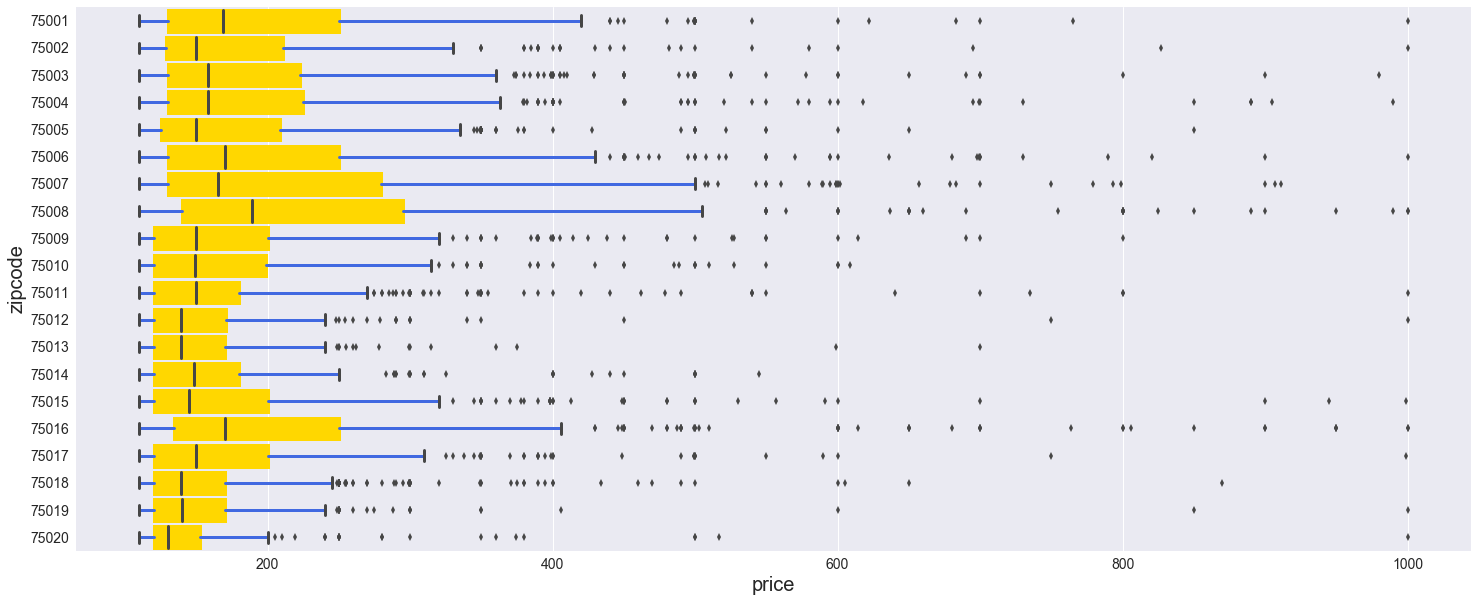

In [19]:
price_per_zip = data.loc[(data.price>=110)&(data.price<=1000), ['zipcode','price','latitude','longitude']]
fig = plt.figure(figsize = (25,10))
sns.boxplot(x='price',y='zipcode' ,data=price_per_zip, orient='h',
            boxprops=dict(color='gold'),
            whiskerprops=dict(color='royalblue'))
plt.show()

The 16th surpassed the 1st and the 6th, sitting just below the 8th

In [20]:
price_per_zip = data.loc[:,['zipcode','price','latitude','longitude']]

In [21]:
# Normalize price
def cap_price(x):
    if x.price>500:
        return 1
    else: 
        return (x.price-8)/(500-8)
price_per_zip['real_price'] = price_per_zip.apply(lambda x: cap_price(x), axis=1)

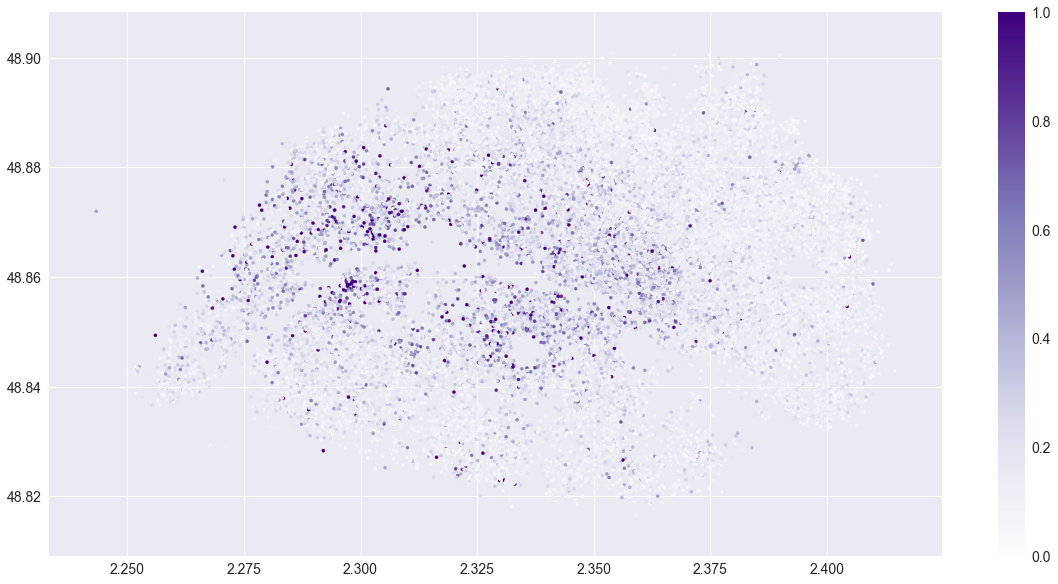

In [22]:
fig = plt.figure(figsize=(20,10))
plt.scatter(price_per_zip.longitude.values, price_per_zip.latitude.values, s=10, c=price_per_zip.real_price.values, cmap='Purples' ,zorder=2, alpha=1)
plt.colorbar()
plt.show()

If the price is considered, should it be used to punish the location score or the listings' or both?

---
### KNN attractions for every listing. 

In [23]:
def get_distEuclid_from_attractions(x):
    d = np.sqrt((paris_attractions.longitude - x.longitude)**2 + (paris_attractions.latitude - x.latitude)**2)
    #return [d.sort_values()] # as a list of a serie
    return [d.values] # As a list of an array

***Takes 1 min***

In [24]:
# Get euclidean distance
mys['attraction'] = mys.apply(lambda x: get_distEuclid_from_attractions(x), axis=1)

In [52]:
# Transform list of distances into dataframe along with its listing id. 
all_dist = []
ndist = []
number_attr = paris_attractions.shape[0]

for idx, content in mys.iterrows():
    all_dist+=[list(np.repeat(idx,number_attr)),list(content.attraction[0][:number_attr])]

idx = []
for i in all_dist[0:-1:2]:
    idx+=i
for d in all_dist[1::2]:
    ndist+=d
    
nDist = pd.DataFrame({'listing' : idx, 'distance': ndist})

In [53]:
mys.drop('attraction', axis=1, inplace=True)

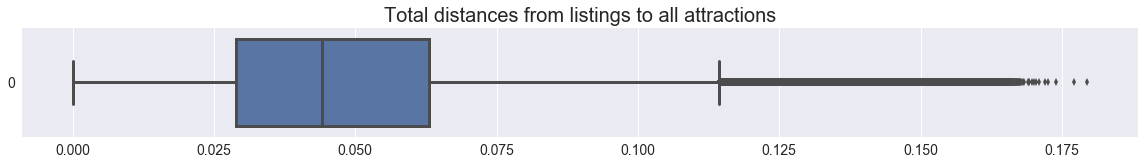

In [54]:
fig = plt.figure(figsize = (20,2))
sns.boxplot(data=nDist.distance, orient="h")
plt.title('Total distances from listings to all attractions')
plt.show()

---

***To grade the listings in terms of their proximity with the touristy places a listing having the longest distance to its closest attraction (top_dist) will have the minimum value. Then the value of a listing will increase as the number of attractions found within the radius set by top_dist. The listing having most of the attractions within that distance will therefore have the maximum score.*** 

***Takes 3 min***

In [10]:

print('Calculating location score ..')
# Get all listings' distance to their closest neighbor
closest_neighbor_distances = nDist.groupby('listing').min()
# Take the longest distance from that
top_dist = closest_neighbor_distances.loc[closest_neighbor_distances.idxmax().values[0]].distance
# Get all the listings with their distances below the top_dist
location_listings = nDist.loc[nDist.distance<=top_dist].groupby('listing').count().rename(columns={'distance':'num_of_attractions'}).sort_values('num_of_attractions', ascending=False)
# Grade the listings with a normalized metric reflecting the number of attractions. 
mys['location_score'] = location_listings.num_of_attractions.apply(lambda x: (x-min(location_listings.num_of_attractions))/(max(location_listings.num_of_attractions)-min(location_listings.num_of_attractions)))

print('Location score retrieved!')


Calculating location score ..
Location score retrieved!


In [13]:
mys.sort_values('location_score', ascending=False).head()

zipcode  latitude  longitude  \
listing_id                                 
15612175      75005    48.851      2.346   
13430660      75005    48.851      2.346   
18234881      75005    48.852      2.346   
1715064       75005    48.852      2.346   
20245564      75005    48.851      2.346   

                                                   attraction  location_score  
listing_id                                                                     
15612175    [[0.00749218511113, 0.0118854231928, 0.0110408...           1.000  
13430660    [[0.00747669421365, 0.0118890595505, 0.0110580...           1.000  
18234881    [[0.00691460048881, 0.0120474016173, 0.0116841...           0.991  
1715064     [[0.00701876757253, 0.0120039078816, 0.0115739...           0.991  
20245564    [[0.00760161069353, 0.0116401009834, 0.0110370...           0.991

In [14]:
# Build dataframe with the number of listings having n number of attractions within the radius of top_dist
num_atrr_vs_num_list = location_listings.reset_index().groupby('num_of_attractions').count()      

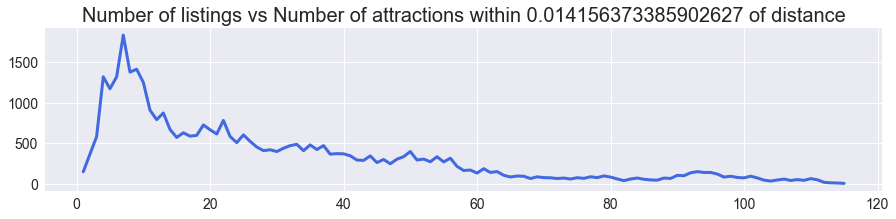

In [15]:
# Plot Number of listings vs Number of attractions
fig=plt.figure(figsize=(15,3))
plt.plot(num_atrr_vs_num_list.index, num_atrr_vs_num_list['listing'], marker='', color='royalblue', linewidth=3, alpha=1, label='Number of listings')
plt.title('Number of listings vs Number of attractions within {0} of distance'.format(top_dist))
plt.show()

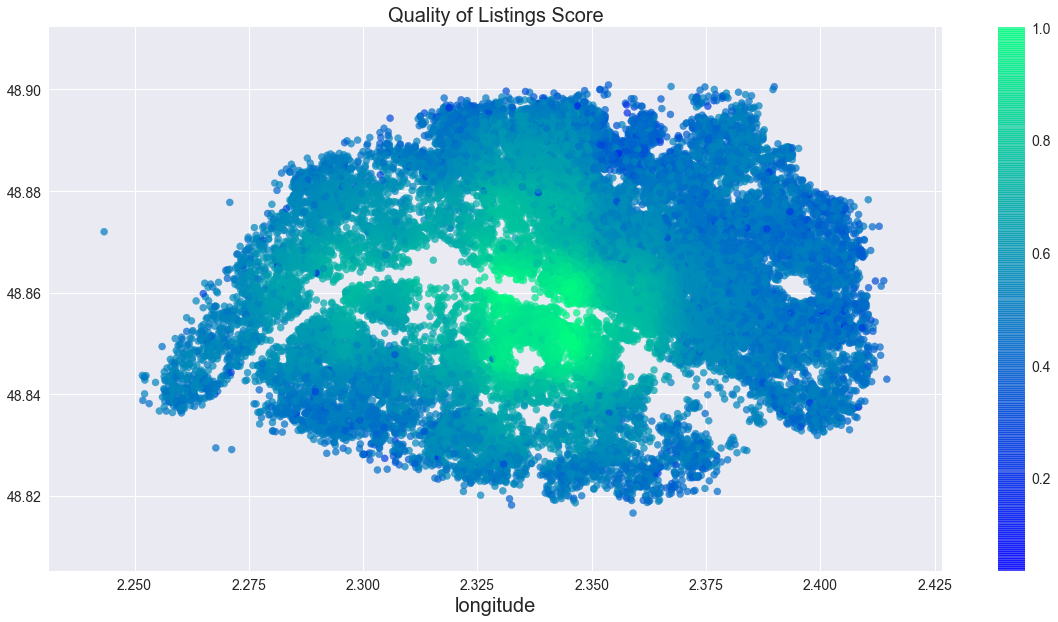

In [64]:
fig = plt.figure(figsize=(20,10))
plt.scatter(mys.longitude.values, mys.latitude.values, s=50, c=mys.location_score.values, cmap='winter' ,zorder=2, alpha=0.7)
plt.title('Quality of Listings Score')
plt.xlabel('longitude')
plt.colorbar()
plt.show()
fig.savefig('../images/PROJ_location_rate.png', bbox_inches='tight')

Merge with location score

*data.review_scores_value = qlty.review_scores_value.apply(lambda x: x*10)*

## How can a grading system be implemented using the following parameters: 
- HOST_SUPERHOST: will have values 100 or 0
- ROOM_TYPE: will be mapped with normalized values as such: 
'Entire home/apt' 100 pts, 'Private room' 50 pts and 'Shared room' 0 pts
- BED_TYPE: will be mapped with normalized values as such: 
Real bed: 100 pts, Pull-out Sofa, Couch, Futon and Airbed: 50pts
- BATHROOMS: will be normalized by 100 as the more bathrooms the fancier the listing is. 
- AMENITIES: has 100 for any listing with 100% of the essential amenities.   
- REVIEW SCORES: They are already normalized scores. 

In [53]:
l_col = ['host_is_superhost','room_type','bed_type','bathrooms','amty_per','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_value']
qlty = data.loc[:,l_col+['zipcode','longitude','latitude']].sample(frac=1)

print('Quantifying listings..')

# Set host_is_superhost values from 0 to 1
qlty.host_is_superhost = qlty.host_is_superhost.apply(lambda x: x)
# Map room type
rt_map = {'Entire home/apt': 1, 'Private room': 0.5, 'Shared room':0}
qlty.room_type = qlty.room_type.map(rt_map)
# Map bed type
bt_map = {'Real Bed': 1, 'Pull-out Sofa': 0.5, 'Airbed':0.5, 'Couch':0, 'Futon':0}
qlty.bed_type = qlty.bed_type.map(bt_map)
# Normalize amty_per
qlty.amty_per = qlty.amty_per.apply(lambda x: x/100)
# Normalize bathrooms
qlty.bathrooms = qlty.bathrooms.apply(lambda x: (x-qlty.bathrooms.min())/(qlty.bathrooms.max()-qlty.bathrooms.min()))
# Normalize review scored by 100
qlty.review_scores_accuracy = qlty.review_scores_accuracy.apply(lambda x: x/10)
qlty.review_scores_cleanliness = qlty.review_scores_cleanliness.apply(lambda x: x/10)
qlty.review_scores_checkin = qlty.review_scores_checkin.apply(lambda x: x/10)
qlty.review_scores_communication = qlty.review_scores_communication.apply(lambda x: x/10)
qlty.review_scores_value = qlty.review_scores_value.apply(lambda x: x/10)
qlty['listings_review_score'] = qlty[l_col].mean(axis=1)


Quantifying listings..


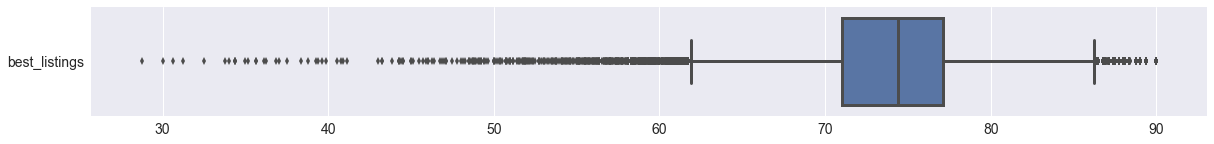

In [17]:
fig = plt.figure(figsize = (20,2))
sns.boxplot(data=qlty.loc[:,['listings_review_score']], orient="h")
plt.show()

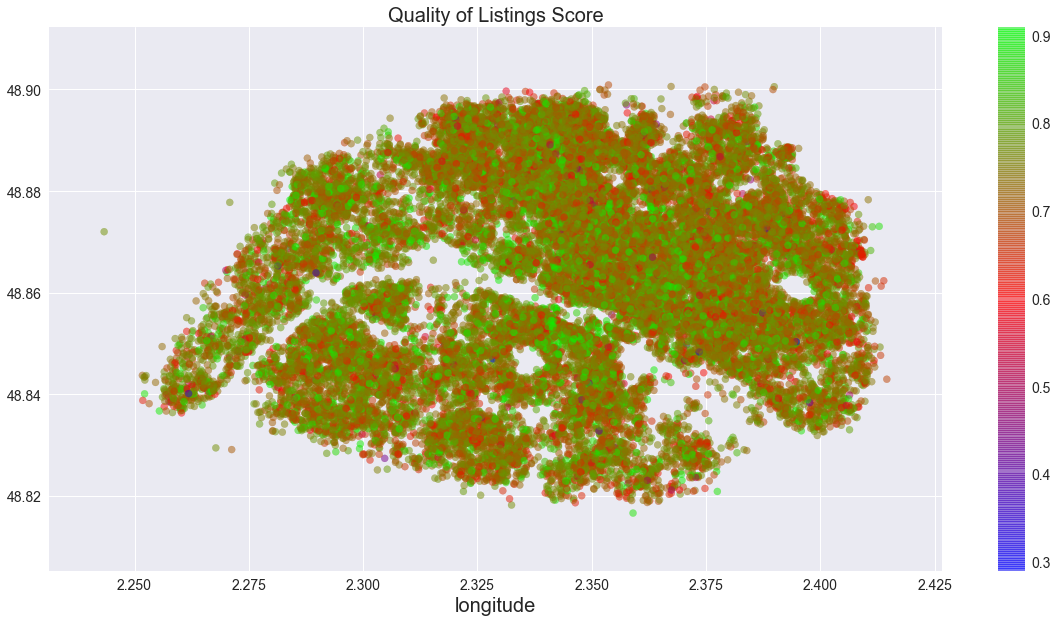

In [61]:
fig = plt.figure(figsize=(20,10))
plt.scatter(qlty.longitude.values, qlty.latitude.values, s=50, c=qlty.listings_review_score.values, cmap='brg' ,zorder=2, alpha=0.5)
plt.title('Quality of Listings Score')
plt.xlabel('longitude')
plt.colorbar()
plt.show()

fig.savefig('../images/PROJ_listing_review_rate.png', bbox_inches='tight')

---
## Getting the Occupancy rate:

Airbnb guests may leave one review after their stay, therefore it can be used as an indicator of airbnb activity. However this option is not obligatory and therefore not all guests leave a review, so the actual booking activity could be much higher. Assuming that this practice of leaving reviews is constant.  The occupancy rate according to Airbnb would be: 

>***Occupancy_rate = MAX(average_length_of_stay, minimum_nights)x(number_of_reviews)***

An average length of stay is configured for each city, multiplied by the estimated bookings for each listing over a period gives the occupancy rate. In this dataset, the average_length_of_stay is set to 4.5 nights. 

Some things to consider is that a listing that just started hosting with Airbnb is less likely to have as much reviews as an older listing. There's at least 7000 listings whose first review dates from this year! To counteract the "old vs new" bias, I will normalize the occupancy rate per month. 

A listing with high availability is susceptible to get more reviews and thus a higher occupancy rate. An Airbnb host can setup a calendar for their listing so that it's only available for a few days or weeks a year.  Other listings are available all year round (except for when it is already booked). 

This poses an ambiguity problem since it can either mean the number of days the listing is supposed to be available all year roudn but it can also mean the remaining days a listing is available for booking thus having a low availability. 

In order to get an accurate rate, I will not consider the availability. So the formula shorts to: 

> ***Average occupancy rate per month = minimum nights x average reviews per month***

..which basically says that the higher the rate of bookings (reviews) per month, the higher the occupancy rate and thus the minimum nights can be removed as it's just a constant. The distribution yielded not a very wide spreaded shape. 

In [3]:
occupancy_scores = data.loc[:,['reviews_per_month', 'zipcode','longitude','latitude']].sample(frac=1)
occupancy_scores.rename(columns={'reviews_per_month':'occupancy_rate'}, inplace=True)


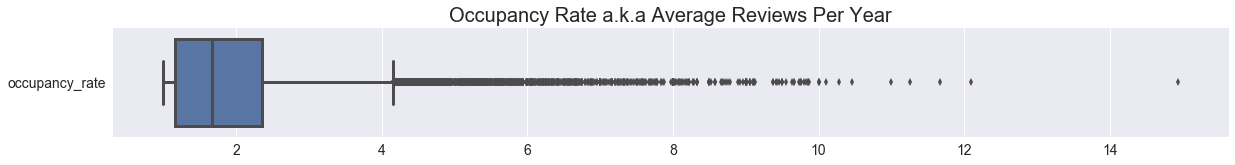

In [4]:
fig = plt.figure(figsize = (20,2))
bp = sns.boxplot(data=occupancy_scores.loc[:,['occupancy_rate']], orient="h", whis=1.5)
plt.title('Occupancy Rate a.k.a Average Reviews Per Year')
plt.show()

In [5]:
occupancy_scores.loc[:,['occupancy_rate']].std()

occupancy_rate    1.156
dtype: float64

Most listings have a really low rate compared to few of their fellow outlier listings, the next steps are an attempt to extend the spectrum of normal rate listings and compress that of the outliers. 

#### 1.5 x IQR Rule
The seaborn boxplot uses whis=1.5 as the default following the 1.5 * IQR rule. One way to define an outlier is anything below Q1 – 1.5 IQR or above Q3 + 1.5 IQR. In this case the outliers are those listings with more than 


In [5]:
# Get the limit from which the remaining points are considered outliers. 
q1 = occupancy_scores.occupancy_rate.quantile(0.25)
q3 = occupancy_scores.occupancy_rate.quantile(0.75)
_iqr = q3-q1
outlier_mark=q3+1.5*_iqr
print(outlier_mark)

4.155022974101922


.. will 4.16 of reviews per month will be considered an outlier. To normalize the rate I will consider these outliers since they can be showing an accurate review rate. However since they can significantly influence the distribution all the outliers will be confined to 1.2 of the space limited by the 1.5 x IQR rule, that is: 

In [6]:
1.1*outlier_mark

4.570525271512114

In [7]:
# Lot a lag of that % wrt the inliers limit to squeeze in the outliers prior to normalization
lag = 1.2*outlier_mark-outlier_mark
or_outliers = occupancy_scores.loc[occupancy_scores.occupancy_rate>outlier_mark,['occupancy_rate']]
outlier_lag = or_outliers.occupancy_rate.max()-or_outliers.occupancy_rate.min()

# LOCAL FUNCTION (needs occupancy_scores.occupancy_rate)
def compress_outliers(x):
    if x >= outlier_mark:
        return (x-or_outliers.occupancy_rate.min())*(lag/outlier_lag)+outlier_mark
    else: 
        return x

or_outliers.occupancy_rate = or_outliers.occupancy_rate.apply(lambda x: compress_outliers(x))
# Update the new occupancy_rate of the outliers
occupancy_scores.loc[occupancy_scores.index.isin(or_outliers.index.values),['occupancy_rate']] = or_outliers.occupancy_rate


In [8]:
occupancy_scores.loc[:,['occupancy_rate']].std()

occupancy_rate    0.938
dtype: float64

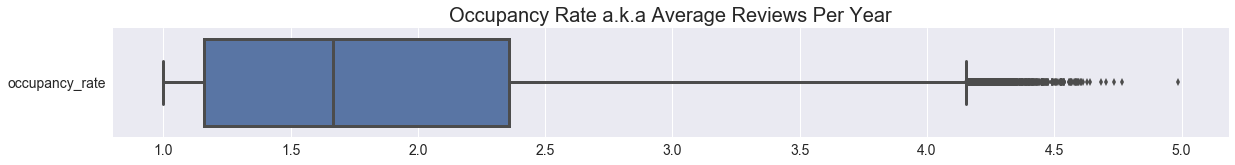

In [9]:
fig = plt.figure(figsize = (20,2))
bp = sns.boxplot(data=occupancy_scores.loc[:,['occupancy_rate']], orient="h")
plt.title('Occupancy Rate a.k.a Average Reviews Per Year')
plt.show()
#fig.savefig('../images/PROJ_Occupancy_rate_scenario_2.png', bbox_inches='tight')


Now the outliers are all compressed within [4.2 and 4.9]

In [10]:
# Normalize: 
m = occupancy_scores.occupancy_rate.min()
M = occupancy_scores.occupancy_rate.max()

occupancy_scores.occupancy_rate = occupancy_scores.occupancy_rate.apply(lambda x: (x-m)/(M-m))


In [11]:
occupancy_scores.loc[:,['occupancy_rate']].std()

occupancy_rate    0.924
dtype: float64

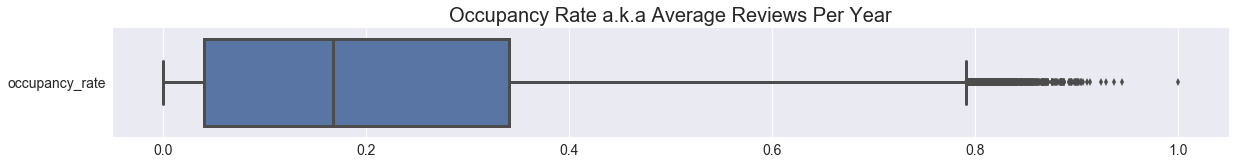

In [12]:
fig = plt.figure(figsize = (20,2))
bp = sns.boxplot(data=occupancy_scores.loc[:,['occupancy_rate']], orient="h")
plt.title('Occupancy Rate a.k.a Average Reviews Per Year')
plt.show()

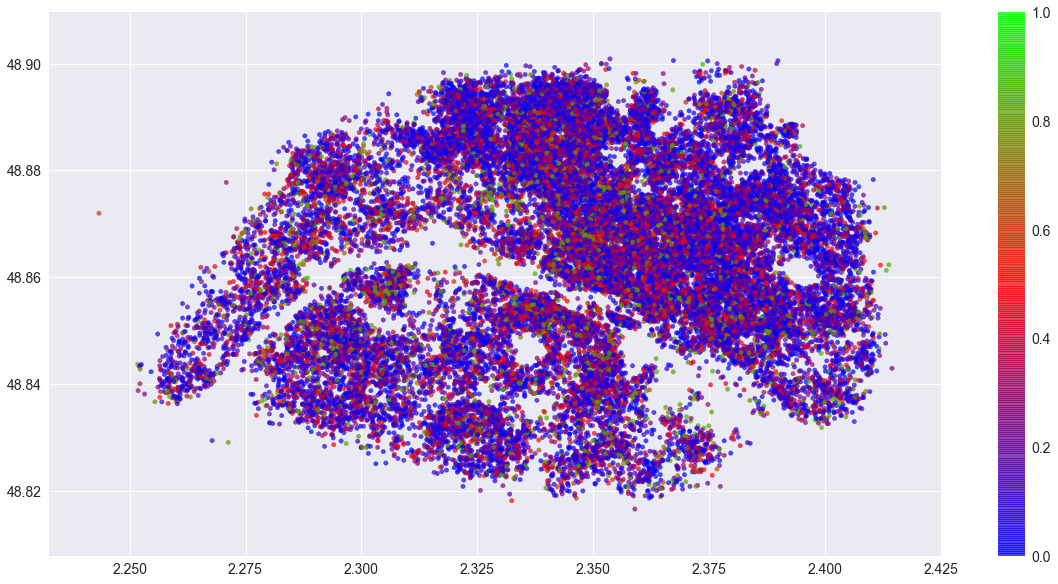

In [13]:
# Plot: 
fig = plt.figure(figsize=(20,10))
plt.scatter(occupancy_scores.longitude.values, occupancy_scores.latitude.values, s=20, c=occupancy_scores.occupancy_rate.values, cmap='brg' ,zorder=2, alpha=0.7)
plt.colorbar()
plt.show()

The above figure shows listings with an occupancy rate that is pretty discriminating: blues are listings with low rate, red listings have an *average* rate and green ones are quite popular amongst Airbnb guests. 

---

A second attempt to exploit the discriminating power of this rate is to ceiling those outliers to the q3+1.5*IQR value.

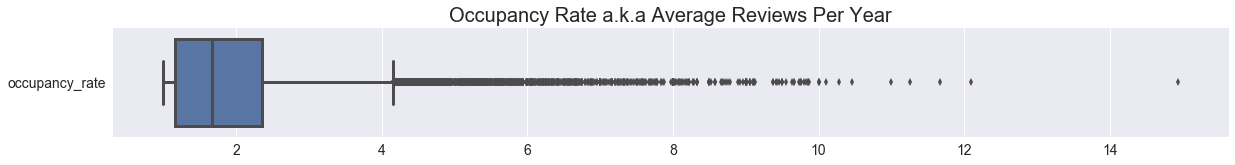

In [6]:
# Starting from the beginning..
fig = plt.figure(figsize = (20,2))
bp = sns.boxplot(data=occupancy_scores.loc[:,['occupancy_rate']], orient="h")
plt.title('Occupancy Rate a.k.a Average Reviews Per Year')
plt.show()

In [7]:
# Get the limit from which the remaining points are considered outliers. 
q1 = occupancy_scores.occupancy_rate.quantile(0.25)
q3 = occupancy_scores.occupancy_rate.quantile(0.75)
_iqr = q3-q1
outlier_mark=q3+1.5*_iqr
print(outlier_mark)

4.155022974101922


In [8]:
occupancy_scores.occupancy_rate = occupancy_scores.occupancy_rate.apply(lambda x: x if x<outlier_mark else outlier_mark)


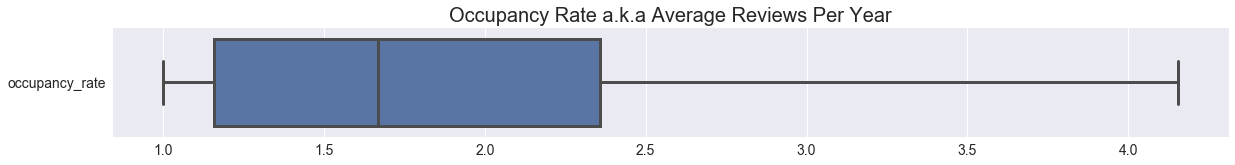

In [9]:
fig = plt.figure(figsize = (20,2))
bp = sns.boxplot(data=occupancy_scores.loc[:,['occupancy_rate']], orient="h")
plt.title('Occupancy Rate a.k.a Average Reviews Per Year')
plt.show()

In [12]:
# Normalize: 
m = occupancy_scores.occupancy_rate.min()
M = occupancy_scores.occupancy_rate.max()

occupancy_scores.occupancy_rate = occupancy_scores.occupancy_rate.apply(lambda x: (x-m)/(M-m))


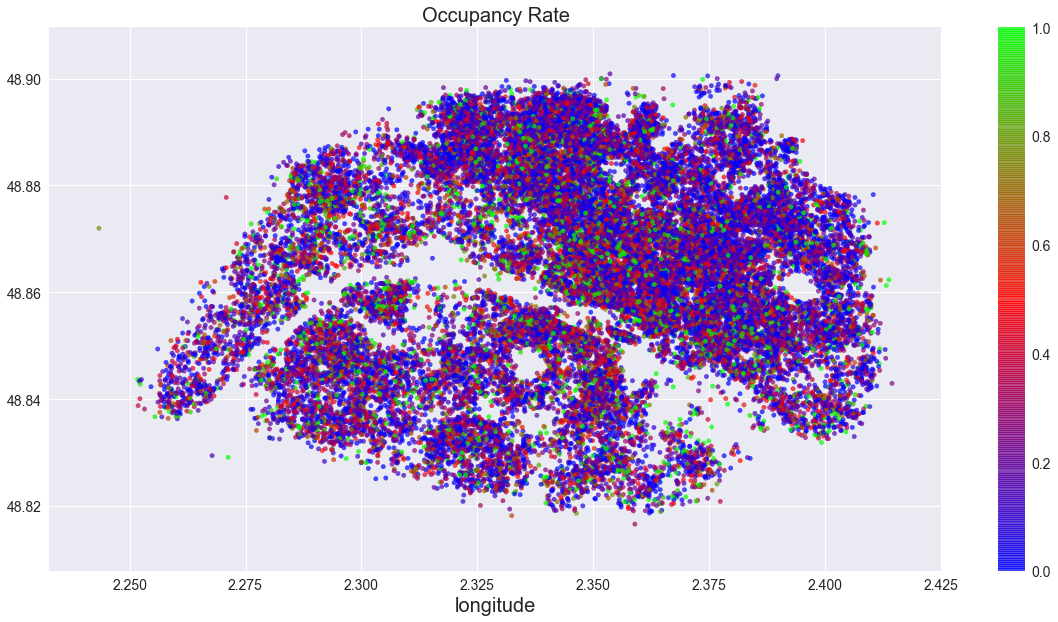

In [62]:
fig = plt.figure(figsize=(20,10))
plt.scatter(occupancy_scores.longitude.values, occupancy_scores.latitude.values, s=20, c=occupancy_scores.occupancy_rate.values, cmap='brg' ,zorder=2, alpha=0.7)
plt.title('Occupancy Rate')
plt.xlabel('longitude')
plt.colorbar()
plt.show()
fig.savefig('../images/PROJ_Occupancy_rate_map.png', bbox_inches='tight')


Setting the outliers to a review_per_month value of q3+(1.5)(IQR) enlarges the spectrum of the reviews_per_month of the inliers. 

---

---

In [1]:
# MAIN SCRIPT 

from analysis_funk import * # Stored functions and variables to plot the map of Paris
from mvp_funk import * 


'''
1. occupancy_scores.occupancy_rate refers to the score defined by the reviews per month
2. qlty.listings_review_score refers to the score defined by the quality of the listing in terms of its predefined parameters
and 
3. myloc.location_score refers to the score defined by the amount of attractions the listing is near to. 
'''



## LOCATION SCORE

print('Calculating location score ..')

myloc = data.loc[:,['zipcode','latitude','longitude','price','review_scores_location']].sample(frac=1)

def get_distEuclid_from_attractions(x):
    d = np.sqrt((paris_attractions.longitude - x.longitude)**2 + (paris_attractions.latitude - x.latitude)**2)
    #return [d.sort_values()] # as a list of a serie
    return [d.values] # As a list of an array

# Get euclidean distance
myloc['attraction'] = myloc.apply(lambda x: get_distEuclid_from_attractions(x), axis=1)

# Transform list of distances into dataframe along with its listing id. 
all_dist = []
ndist = []
number_attr = paris_attractions.shape[0]
for idx, content in myloc.iterrows():
    all_dist+=[list(np.repeat(idx,number_attr)),list(content.attraction[0][:number_attr])]
idx = []
for i in all_dist[0:-1:2]:
    idx+=i
for d in all_dist[1::2]:
    ndist+=d
nDist = pd.DataFrame({'listing' : idx, 'distance': ndist})
myloc.drop('attraction', axis=1, inplace=True)

# Get all listings' distance to their closest neighbor
closest_neighbor_distances = nDist.groupby('listing').min()

# Take the longest distance from that
top_dist = closest_neighbor_distances.loc[closest_neighbor_distances.idxmax().values[0]].distance

# Get all the listings with their distances below the top_dist
location_listings = nDist.loc[nDist.distance<=top_dist].groupby('listing').count().rename(columns={'distance':'num_of_attractions'}).sort_values('num_of_attractions', ascending=False)

# Grade the listings with a normalized metric reflecting the number of attractions. 
myloc['location_score'] = location_listings.num_of_attractions.apply(lambda x: (x-min(location_listings.num_of_attractions))/(max(location_listings.num_of_attractions)-min(location_listings.num_of_attractions)))

# Build dataframe with the number of listings having n number of attractions within the radius of top_dist
num_atrr_vs_num_list = location_listings.reset_index().groupby('num_of_attractions').count()      

# Normalize review_scores_location
myloc['review_location'] = (myloc.review_scores_location-min(myloc.review_scores_location))/(max(myloc.review_scores_location)-min(myloc.review_scores_location))

# Merge location_score with review_scores_location
myloc['location_score'] = myloc.loc[:,['location_score','review_location']].mean(axis=1)



## OCCUPANCY RATE


print('Calculating occupancy rate ..')

occupancy_scores = data.loc[:,['reviews_per_month', 'zipcode','longitude','latitude']].sample(frac=1)
occupancy_scores.rename(columns={'reviews_per_month':'occupancy_rate'}, inplace=True)

# Get the limit from which the remaining points are considered outliers. 
q1 = occupancy_scores.occupancy_rate.quantile(0.25)
q3 = occupancy_scores.occupancy_rate.quantile(0.75)
_iqr = q3-q1
outlier_mark=q3+1.5*_iqr

occupancy_scores.occupancy_rate = occupancy_scores.occupancy_rate.apply(lambda x: x if x<outlier_mark else outlier_mark)

# Normalize: 
m = occupancy_scores.occupancy_rate.min()
M = occupancy_scores.occupancy_rate.max()
occupancy_scores.occupancy_rate = occupancy_scores.occupancy_rate.apply(lambda x: (x-m)/(M-m))



## LISTING'S REVIEW RATE


print("Calculating listing's review rate ..")

q_col = ['host_is_superhost','room_type','bed_type','bathrooms','amty_per','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_value']
qlty = data.loc[:,q_col+['zipcode','longitude','latitude']].sample(frac=1)

# Set host_is_superhost values from 0 to 1
qlty.host_is_superhost = qlty.host_is_superhost.apply(lambda x: x)
# Map room type
rt_map = {'Entire home/apt': 1, 'Private room': 0.5, 'Shared room':0}
qlty.room_type = qlty.room_type.map(rt_map)
# Map bed type
bt_map = {'Real Bed': 1, 'Pull-out Sofa': 0.5, 'Airbed':0.5, 'Couch':0, 'Futon':0}
qlty.bed_type = qlty.bed_type.map(bt_map)
# Normalize amty_per
qlty.amty_per = qlty.amty_per.apply(lambda x: x/100)
# Normalize bathrooms
qlty.bathrooms = qlty.bathrooms.apply(lambda x: (x-qlty.bathrooms.min())/(qlty.bathrooms.max()-qlty.bathrooms.min()))
# Normalize review scored by 100
qlty.review_scores_accuracy = qlty.review_scores_accuracy.apply(lambda x: x/10)
qlty.review_scores_cleanliness = qlty.review_scores_cleanliness.apply(lambda x: x/10)
qlty.review_scores_checkin = qlty.review_scores_checkin.apply(lambda x: x/10)
qlty.review_scores_communication = qlty.review_scores_communication.apply(lambda x: x/10)
qlty.review_scores_value = qlty.review_scores_value.apply(lambda x: x/10)
qlty['listings_review_score'] = qlty[l_col].mean(axis=1)


print('Scores retrieval completed!')

# Merge results : Nested merge
scores = pd.merge(pd.merge(qlty.loc[:,['zipcode','longitude','latitude','listings_review_score']], occupancy_scores.loc[:,['occupancy_rate']], right_index=True, left_index=True), myloc.loc[:,['location_score']], right_index=True, left_index=True)


Calculating location score ..
Calculating occupancy rate ..
Calculating listing's review rate ..


In [30]:
scores.to_csv('scores.csv')

# Analysis

In [58]:
scores.describe()

zipcode  longitude   latitude  listings_review_score  occupancy_rate  \
count  36858.000  36858.000  36858.000              36858.000       36858.000   
mean   75012.091      2.347     48.864                  0.745           0.290   
std        5.534      0.032      0.018                  0.063           0.293   
min    75001.000      2.243     48.817                  0.290           0.000   
25%    75008.000      2.327     48.851                  0.712           0.050   
50%    75012.000      2.349     48.865                  0.746           0.211   
75%    75017.000      2.371     48.879                  0.773           0.430   
max    75020.000      2.415     48.901                  0.909           1.000   

       location_score  
count       36858.000  
mean            0.598  
std             0.129  
min             0.035  
25%             0.513  
50%             0.570  
75%             0.671  
max             1.000

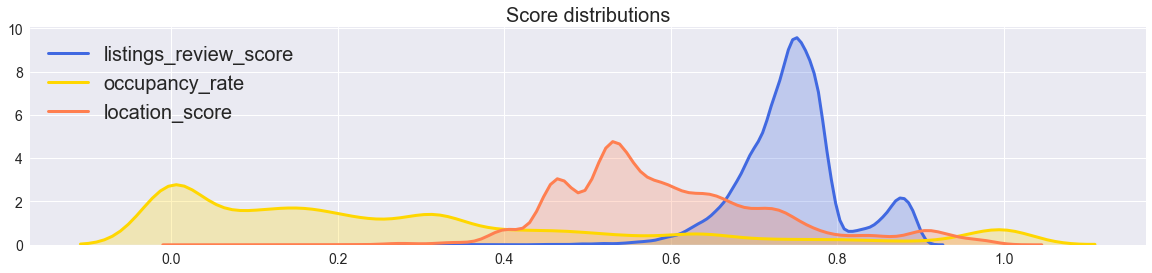

In [81]:
fig = plt.figure(figsize=(20,4))
p1=sns.kdeplot(scores.listings_review_score, shade=True, color="royalblue")
p2=sns.kdeplot(scores.occupancy_rate, shade=True, color="gold")
p3=sns.kdeplot(scores.location_score, shade=True, color="coral")
plt.title('Score distributions')
plt.legend(loc=2, prop={'size': 20})
plt.show()
fig.savefig('../images/PROJ_score_distributions.png', bbox_inches='tight')

In [82]:
scores.head()

zipcode  longitude  latitude  listings_review_score  \
listing_id                                                        
23683173      75020      2.382    48.869                  0.622   
593463        75006      2.318    48.845                  0.677   
8302792       75020      2.388    48.870                  0.764   
19679323      75015      2.304    48.839                  0.767   
1470752       75010      2.353    48.873                  0.757   

            occupancy_rate  location_score  
listing_id                                  
23683173             0.000           0.393  
593463               0.423           0.689  
8302792              0.317           0.509  
19679323             0.079           0.535  
1470752              0.683           0.543

In [101]:
# Best Location
best_location = scores.loc[scores.location_score>=scores.location_score.mean()].index.values
# Best listing
best_listing = scores.loc[scores.listings_review_score>=scores.listings_review_score.mean()].index.values
# Best occupancy rated listings
best_occupancy = scores.loc[scores.occupancy_rate>=scores.occupancy_rate.mean()]

Let A be the number of listings classified with a high listing score and a high occupancy rate
Let B be the number of listings classified with a high location score and a high occupancy rate

In [112]:
A = best_occupancy.loc[(~best_occupancy.index.isin(best_location))&(best_occupancy.index.isin(best_listing))]
B = best_occupancy.loc[(~best_occupancy.index.isin(best_listing))&(best_occupancy.index.isin(best_location))]

In [114]:
# Probability that the listing has a high listing score and a high occupancy rate
A.shape[0]/scores.shape[0]

0.10261001682131424

In [115]:
# Probability that the listing has a high location score and a high occupancy rate
B.shape[0]/scores.shape[0]

0.08587009604427805

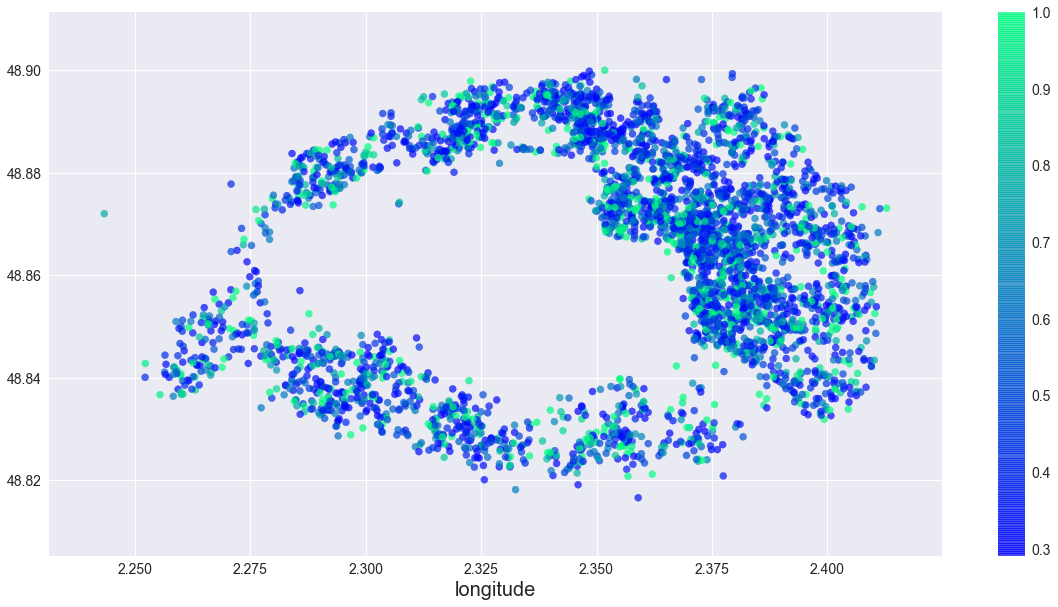

In [123]:
fig = plt.figure(figsize=(20,10))
plt.scatter(A.longitude.values, A.latitude.values, s=50, c=A.occupancy_rate.values, cmap='winter' ,zorder=2, alpha=0.7)
plt.xlabel('longitude')
plt.colorbar()
plt.show()
fig.savefig('../images/PROJ_popular_high_occupancy.png', bbox_inches='tight')


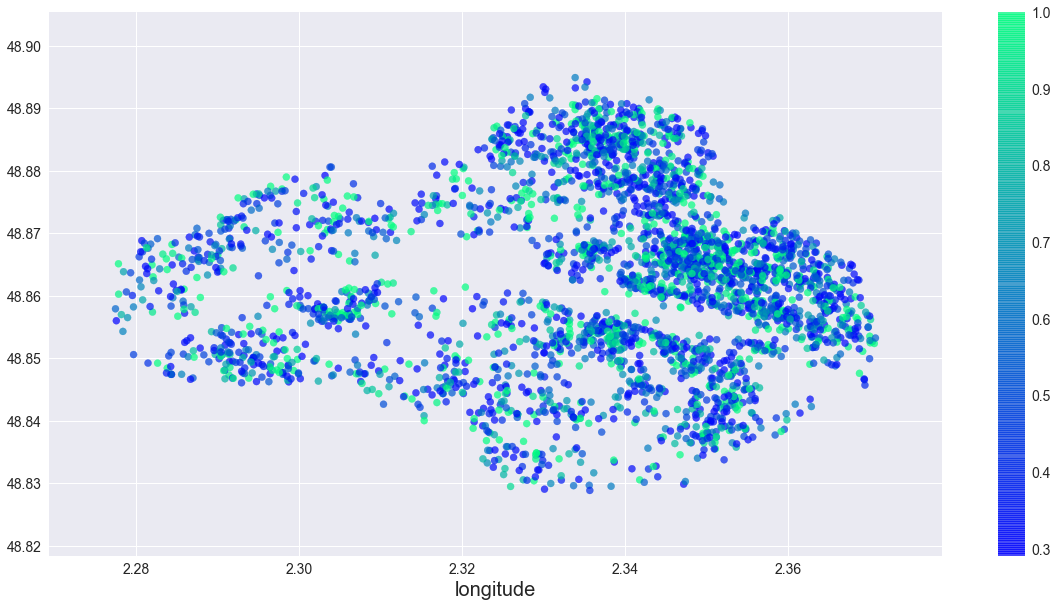

In [124]:
fig = plt.figure(figsize=(20,10))
plt.scatter(B.longitude.values, B.latitude.values, s=50, c=B.occupancy_rate.values, cmap='winter' ,zorder=2, alpha=0.7)
plt.xlabel('longitude')
plt.colorbar()
plt.show()
fig.savefig('../images/PROJ_well_located_high_occupancy.png', bbox_inches='tight')